Saving oIumJ.png to oIumJ.png


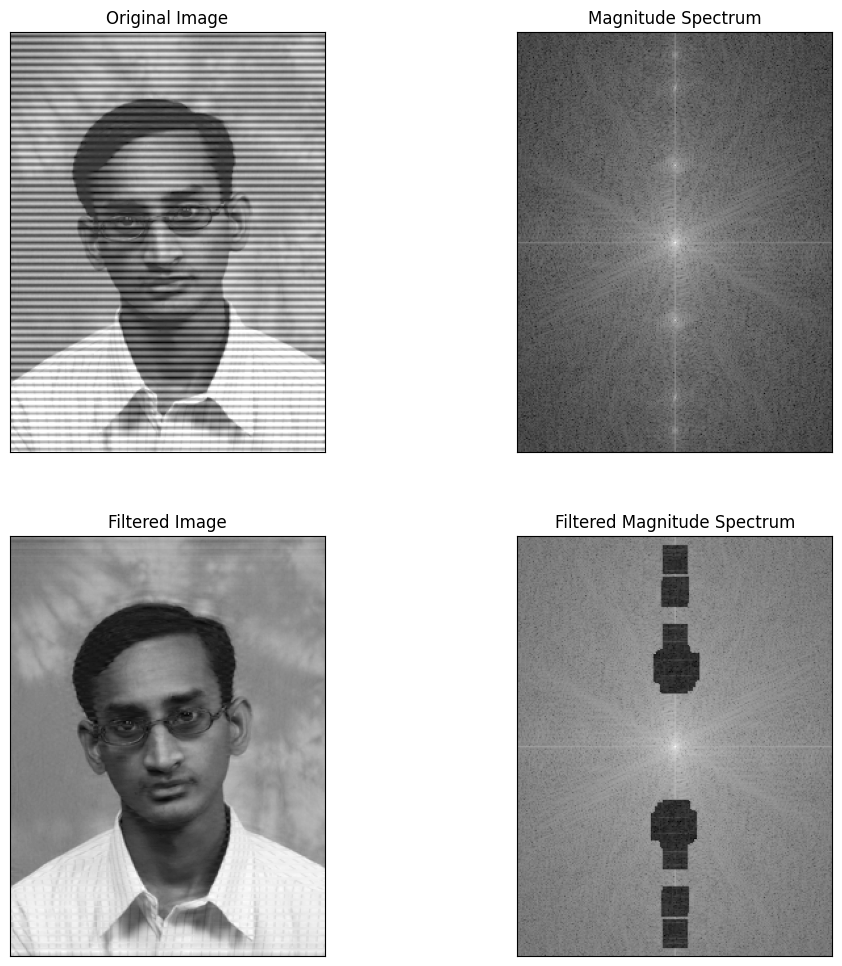

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab import files
from io import BytesIO
from PIL import Image
import heapq

# Function to convert to frequency domain
def to_frequency_domain(img):
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]) + 1)
    return dft_shift, magnitude_spectrum

# Function to find brightest spots in the spectrum
def find_brightest_spots(magnitude, num_spots=5):
    rows, cols = magnitude.shape
    crow, ccol = rows // 2, cols // 2

    # Avoiding the center
    mask_size = 50
    masked_magnitude = magnitude.copy()
    # sets 2*mask_size around the center to 0
    masked_magnitude[crow-mask_size:crow+mask_size, ccol-mask_size:ccol+mask_size] = 0

    # Find the brightest spots
    flat = masked_magnitude.flatten()
    indices = heapq.nlargest(num_spots, range(len(flat)), flat.take)
    # convert back to 2D.
    # i%cols calculates the column
    # i//cols calculates the row
    spots = [(i % cols - ccol, i // cols - crow) for i in indices]
    return spots

# Function to apply notch filter
def apply_notch_filter(dft_shift, notch_radius=10, notch_positions=[]):
    rows, cols = dft_shift.shape[:2]
    crow, ccol = rows // 2, cols // 2

    # mask with same size as the dft_shift. used to block out certain frequencies
    mask = np.ones((rows, cols, 2), np.uint8)

    # each specified notch position will be set zero in a square with radius notch_radius
    # (x,y) and (-x,-y) are masked because frequency domain is symmetrical
    for (x, y) in notch_positions:
        mask[crow + y - notch_radius:crow + y + notch_radius, ccol + x - notch_radius:ccol + x + notch_radius] = 0
        mask[crow - y - notch_radius:crow - y + notch_radius, ccol - x - notch_radius:ccol - x + notch_radius] = 0

    fshift = dft_shift * mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])
    return img_back

# Upload file
uploaded = files.upload()
filename = next(iter(uploaded))
image = Image.open(BytesIO(uploaded[filename]))
image = np.array(image)

# Check if the image is already in grayscale
if len(image.shape) == 3:
    # Convert to Grayscale if it's a color image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
else:
    gray_image = image


# Frequency domain conversion
fshift, magnitude_spectrum = to_frequency_domain(gray_image)

# Find the brightest spots for notch filter
notch_positions = find_brightest_spots(magnitude_spectrum, num_spots=200)

# Apply notch filter
filtered_img = apply_notch_filter(fshift, notch_radius=10, notch_positions=notch_positions)

# Convert the filtered image back to the frequency domain to visualize the spectrum
_, filtered_magnitude_spectrum = to_frequency_domain(filtered_img)

# Display results
plt.figure(figsize=(12, 12))
plt.subplot(221), plt.imshow(gray_image, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(filtered_img, cmap='gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(filtered_magnitude_spectrum, cmap='gray')
plt.title('Filtered Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()


Saving period_input.jpg to period_input (2).jpg


<ipython-input-3-dca4dad560ee>:45: RuntimeWarning: divide by zero encountered in double_scalars
  mask[i, j] *= 1 / (1 + (notch_radius / d1)**(2 * order))
<ipython-input-3-dca4dad560ee>:46: RuntimeWarning: divide by zero encountered in double_scalars
  mask[i, j] *= 1 / (1 + (notch_radius / d2)**(2 * order))


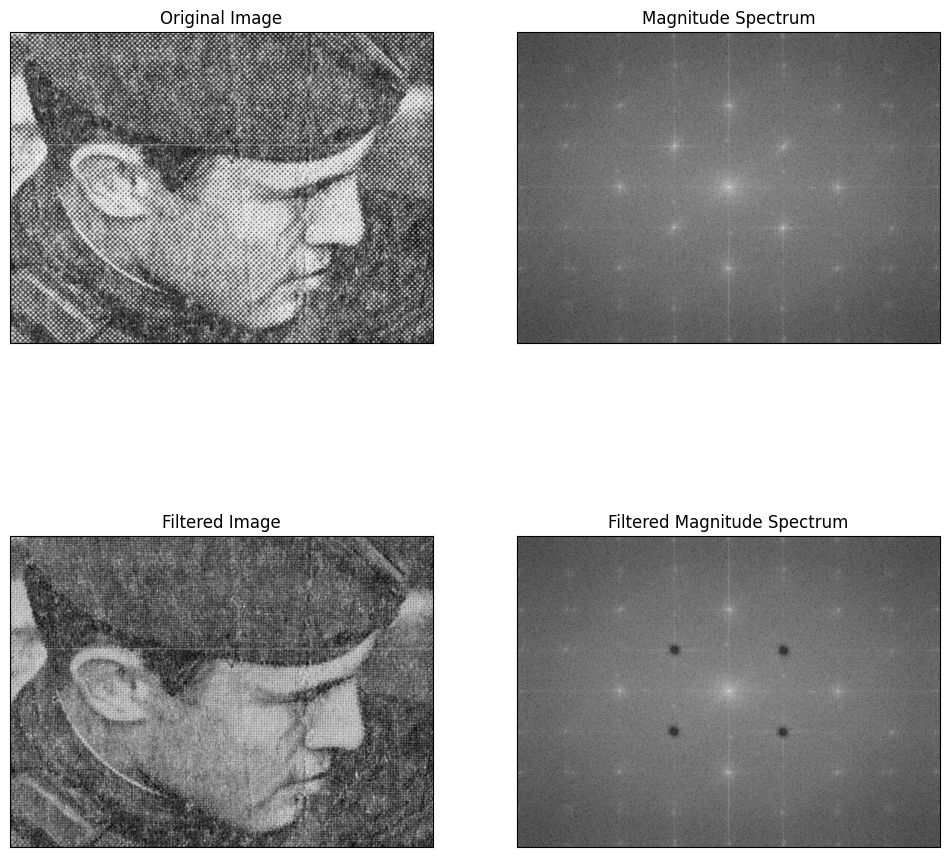

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab import files
from io import BytesIO
from PIL import Image
import heapq

# Function to convert to frequency domain
def to_frequency_domain(img):
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]) + 1)
    return dft_shift, magnitude_spectrum

# Function to find brightest spots in the spectrum
def find_brightest_spots(magnitude, num_spots=5):
    rows, cols = magnitude.shape
    crow, ccol = rows // 2, cols // 2

    # Avoiding the center
    mask_size = 10
    masked_magnitude = magnitude.copy()
    masked_magnitude[crow-mask_size:crow+mask_size, ccol-mask_size:ccol+mask_size] = 0

    # Find the brightest spots
    flat = masked_magnitude.flatten()
    indices = heapq.nlargest(num_spots, range(len(flat)), flat.take)
    spots = [(i % cols - ccol, i // cols - crow) for i in indices]
    return spots

# Function to apply Butterworth notch filter
def apply_butterworth_notch_filter(dft_shift, notch_radius=10, notch_positions=[], order=2):
    rows, cols = dft_shift.shape[:2]
    crow, ccol = rows // 2, cols // 2

    mask = np.ones((rows, cols, 2), np.float32)

    for (x, y) in notch_positions:
        for i in range(rows):
            for j in range(cols):
                d1 = np.sqrt((i - (crow + y))**2 + (j - (ccol + x))**2)
                d2 = np.sqrt((i - (crow - y))**2 + (j - (ccol - x))**2)

                mask[i, j] *= 1 / (1 + (notch_radius / d1)**(2 * order))
                mask[i, j] *= 1 / (1 + (notch_radius / d2)**(2 * order))

    fshift = dft_shift * mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])
    return img_back

# Upload file
uploaded = files.upload()
filename = next(iter(uploaded))
image = Image.open(BytesIO(uploaded[filename]))
image = np.array(image)

# Check if the image is already in grayscale
if len(image.shape) == 3:
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
else:
    gray_image = image

# Frequency domain conversion
fshift, magnitude_spectrum = to_frequency_domain(gray_image)

# Find the brightest spots for notch filter
notch_positions = find_brightest_spots(magnitude_spectrum, num_spots=4)

# Apply Butterworth notch filter
filtered_img = apply_butterworth_notch_filter(fshift, notch_radius=10, notch_positions=notch_positions)

# Convert the filtered image back to the frequency domain to visualize the spectrum
_, filtered_magnitude_spectrum = to_frequency_domain(filtered_img)

# Display results
plt.figure(figsize=(12, 12))
plt.subplot(221), plt.imshow(gray_image, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(filtered_img, cmap='gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(filtered_magnitude_spectrum, cmap='gray')
plt.title('Filtered Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()
